Most of the core algorithmic stuff is packaged into _SDOptimizer_. We instantiate an object and then load in the data from a single smoke source which was obtained from Katie's simulation. This represents the smoke consentation at a point on the wall at a certain time. 

In [1]:
import numpy as np
import SDOptimizer as SDOmodule
from SDOptimizer.SDOptimizer import SDOptimizer
import matplotlib as plt
#import importlib

#importlib.reload(SDOmodule)
plt.rcParams["figure.figsize"] = (10, 7)
SMOKE_DATA_DIR = "data/smoke_data_full3D" # this data was emailed around
FALSE_ALARM_DATA_DIR = "data/bike_data_full3D"
INFEASIBLE = [(3, -2, 4, -1)] # The infeasible region

SDO = SDOptimizer()

What we really want to extract from the data is the minimum time to alarm at any location on the wall. _SDOptimizer.get\_time\_to\_alarm()_ takes the most-recently loaded data and returns this information. The data can be optionally flipped about the x or y axis to provide augmented data for testing, since we only have one smoke source. You can also select which one to visualize. Furthermore, you can add infeasible locations where it is impossible to place a detector.

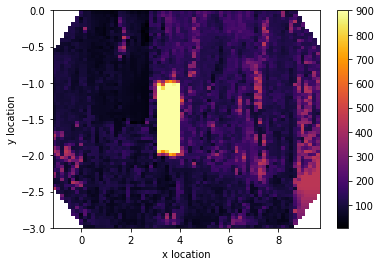

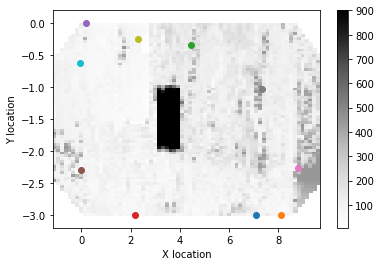

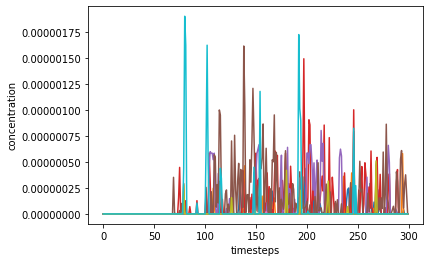

In [2]:
SDO.load_timestep_directory(SMOKE_DATA_DIR)
source1 = SDO.get_time_to_alarm(False, False, infeasible_locations=INFEASIBLE) # the default value of flip is false, so this is simply included for clarity
source2 = SDO.get_time_to_alarm(True, False, infeasible_locations=INFEASIBLE) # flip about the x axis
source3 = SDO.get_time_to_alarm(False, True, infeasible_locations=INFEASIBLE) # flip about the x axis
source4 = SDO.get_time_to_alarm(False, False, infeasible_locations=INFEASIBLE, visualize=True) # flip about both axis 
smoke_sources = [source1, source2, source3, source4]

This is where we load the false alarm sources. In the future these should be individual files per source rather than augmenting them. 

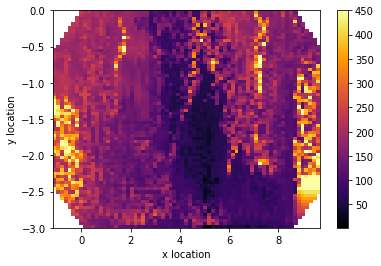

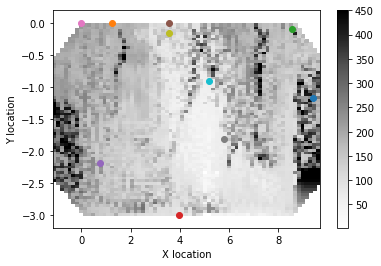

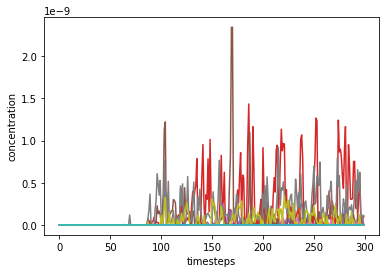

In [3]:
SDO.load_timestep_directory(FALSE_ALARM_DATA_DIR)
bad_source1 = SDO.get_time_to_alarm(False, False) # the default value of flip is false, so this is simply included for clarity
bad_source2 = SDO.get_time_to_alarm(True, False) # flip about the x axis
bad_source3 = SDO.get_time_to_alarm(False, True) # flip about the x axis
bad_source4 = SDO.get_time_to_alarm(False, False, visualize=True) # flip about both axis 
bad_smoke_sources = [bad_source1, bad_source2, bad_source3, bad_source4]

Now, we generate our objective function from this data. This function maps from the locations of all smoke detectors, to the worst-case time to alarm. This is done by finding, for each smoke source, the minimum time to alarm for any detector, and then taking the largest value, representing the worst-case smoke source. This was formalized in notes I sent in an email a while ago.

The behavior of the objective function can be somewhat visualized by fixing the location of _n_ smoke detectors and then sweeping the last one. Each smoke source is also shown.

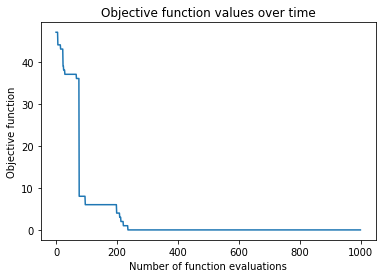

<Figure size 432x288 with 0 Axes>

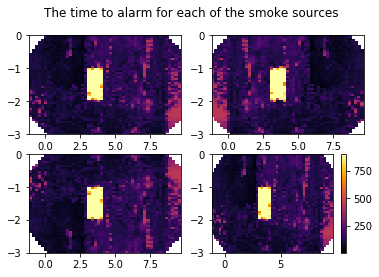

<Figure size 432x288 with 0 Axes>

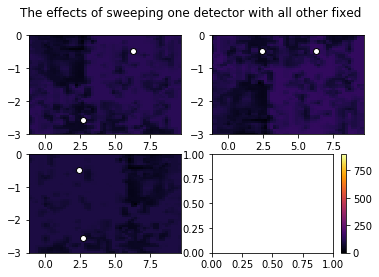

The bounds are now [(-1.169999957, 9.710000037999999), (-3.0, -3.200361128e-17), (-1.169999957, 9.710000037999999), (-3.0, -3.200361128e-17), (-1.169999957, 9.710000037999999), (-3.0, -3.200361128e-17)]
The locations are: (2.401, -0.474), (2.672, -2.559), (6.266, -0.477), 
the result of the optimization is:
      fun: 0.0
 message: 'Maximum number of iterations has been exceeded.'
    nfev: 90097
     nit: 1000
 success: False
    vals: [47.0, 47.0, 47.0, 47.0, 47.0, 47.0, 44.0, 44.0, 44.0, 44.0, 44.0, 44.0, 44.0, 44.0, 44.0, 43.0, 43.0, 43.0, 43.0, 43.0, 43.0, 43.0, 43.0, 39.0, 39.0, 38.0, 38.0, 38.0, 38.0, 37.0, 37.0, 37.0, 37.0, 37.0, 37.0, 37.0, 37.0, 37.0, 37.0, 37.0, 37.0, 37.0, 37.0, 37.0, 37.0, 37.0, 37.0, 37.0, 37.0, 37.0, 37.0, 37.0, 37.0, 37.0, 37.0, 37.0, 37.0, 37.0, 37.0, 37.0, 37.0, 37.0, 37.0, 37.0, 37.0, 37.0, 37.0, 36.0, 36.0, 36.0, 36.0, 36.0, 36.0, 36.0, 36.0, 36.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 6.

In [4]:
description = SDO.optimize(smoke_sources, 3, genetic=True, visualize=True, type="worst_case")
print("the result of the optimization is:\n {}".format(description))

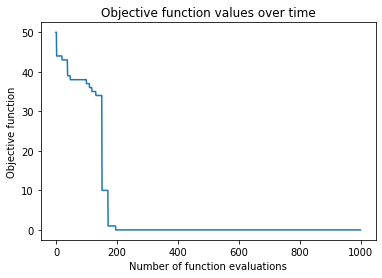

<Figure size 432x288 with 0 Axes>

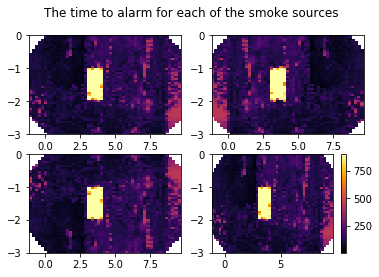

<Figure size 432x288 with 0 Axes>

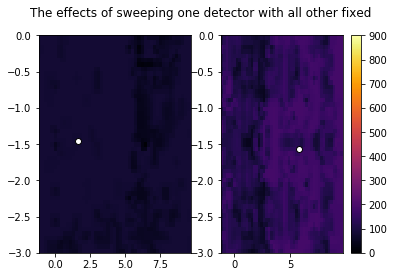

The bounds are now [(-1.169999957, 9.710000037999999), (-3.0, -3.200361128e-17), (-1.169999957, 9.710000037999999), (-3.0, -3.200361128e-17)]
The locations are: (5.761, -1.571), (1.625, -1.455), 
the result of the optimization is:
      fun: 0.0
 message: 'Maximum number of iterations has been exceeded.'
    nfev: 60065
     nit: 1000
 success: False
    vals: [50.0, 50.0, 43.99999999999999, 43.99999999999999, 43.99999999999999, 43.99999999999999, 43.99999999999999, 43.99999999999999, 43.99999999999999, 43.99999999999999, 43.99999999999999, 43.99999999999999, 43.99999999999999, 43.99999999999999, 43.99999999999999, 43.99999999999999, 43.99999999999999, 43.99999999999999, 43.99999999999999, 43.99999999999999, 43.0, 43.0, 43.0, 43.0, 43.0, 43.0, 43.0, 43.0, 43.0, 43.0, 43.0, 43.0, 43.0, 43.0, 43.0, 43.0, 43.0, 43.0, 39.0, 39.0, 39.0, 39.0, 39.0, 39.0, 39.0, 39.0, 39.0, 38.0, 38.0, 38.0, 38.0, 38.0, 38.0, 38.0, 38.0, 38.0, 38.0, 38.0, 38.0, 38.0, 38.0, 38.0, 38.0, 38.0, 38.0, 38.0, 38.0, 

In [5]:
# running with two detectors
description = SDO.optimize(smoke_sources, 2, genetic=True)
print("the result of the optimization is:\n {}".format(description))

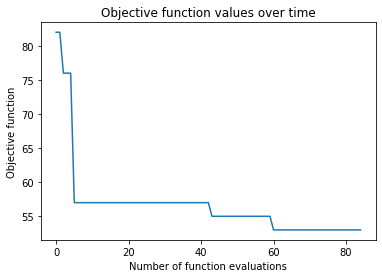

<Figure size 432x288 with 0 Axes>

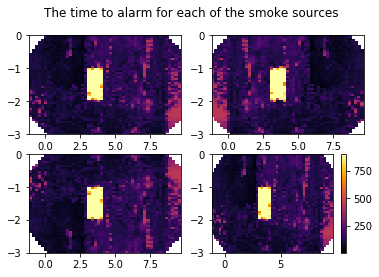

<Figure size 432x288 with 0 Axes>

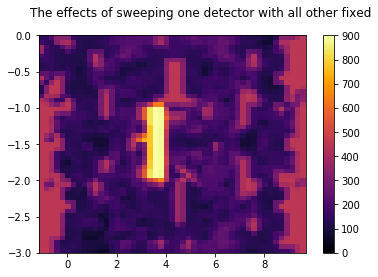

The bounds are now [(-1.169999957, 9.710000037999999), (-3.0, -3.200361128e-17)]
The locations are: (2.637, -2.738), 
the result of the optimization is:
      fun: 52.99999999999999
 message: 'Optimization terminated successfully.'
    nfev: 2583
     nit: 85
 success: True
    vals: [82.0, 82.0, 76.0, 76.0, 76.0, 57.0, 57.0, 57.0, 57.0, 57.0, 57.0, 57.0, 57.0, 57.0, 57.0, 57.0, 57.0, 57.0, 57.0, 57.0, 57.0, 57.0, 57.0, 57.0, 57.0, 57.0, 57.0, 57.0, 57.0, 57.0, 57.0, 57.0, 57.0, 57.0, 57.0, 57.0, 57.0, 57.0, 57.0, 57.0, 57.0, 57.0, 57.0, 55.0, 55.0, 55.0, 55.0, 55.0, 55.0, 55.0, 55.0, 55.0, 55.0, 55.0, 55.0, 55.0, 55.0, 55.0, 55.0, 55.0, 53.00000000000001, 53.0, 53.0, 52.99999999999999, 52.99999999999999, 52.99999999999999, 52.99999999999999, 52.99999999999999, 52.99999999999999, 52.99999999999999, 52.99999999999999, 52.99999999999999, 52.99999999999999, 52.99999999999999, 52.99999999999999, 52.99999999999999, 52.99999999999999, 52.99999999999999, 52.99999999999999, 52.99999999999999, 

In [6]:
# running with one detector
description = SDO.optimize(smoke_sources, 1, genetic=True)
print("the result of the optimization is:\n {}".format(description))

min x : -1.169999957, max x : 9.710000037999999, min y : -3.0, max y : -3.200361128e-17


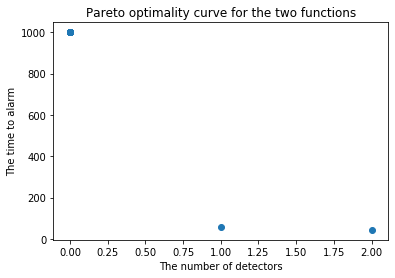

the result of the optimization is:


/home/david/dev/SmokeDetectorOptimization/SDOptimizer/SDOptimizer.py:726: UserWarning: Can't visualize the objective values for a multiobjective run
  for solution in algorithm.result:


In [7]:
description = SDO.optimize(smoke_sources[:3], 3, genetic=True, multiobjective=True, multiobjective_type="counting", visualize=True, type="worst_case")

print("the result of the optimization is:\n {}".format(description))

min x : -1.169999957, max x : 9.710000037999999, min y : -3.0, max y : -3.200361128e-17


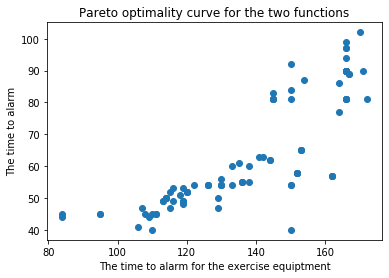

the result of the optimization is:


In [8]:
description = SDO.optimize(smoke_sources[:3], 3, genetic=True, multiobjective=True, multiobjective_type="competing_function", bad_sources=bad_smoke_sources, visualize=True, type="worst_case")

print("the result of the optimization is:\n {}".format(description))